# Data Pre-processing

### Deletion of "MaximumAbsoluteVibration.mean" & "Time"
- Delete "MaximumAbsoluteVibration.Mean" because it causes multicollinearity.
- Delete "Time" because we do not use it, we will use ReadableTime.

In [1]:
import pandas as pd

# reads labeled sensordata to a dataframe
data = pd.read_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/sensor_breakdown_label_elim.xlsx")

# deletes "Time" & "MaximumAbsoluteVibration.mean"
data = data.drop(columns=['Time', 'MaximumAbsoluteVibration.mean'])


### Extra feature: "Active"

Adding the feature "Active", which represents the lifetime of the machine. More specifically, it represents the time since previous breakdown.

This feature is needed in Survival Analysis.
- event = "Breakdown"
- lifetime = "Active"

In [2]:
import pandas as pd

# initializes variable to store the last 'active' value before a breakdown
last_active_value = None

# initializes variable to store the end date of the last breakdown
breakdown_end_date = pd.Timestamp("8/31/2022 12:05:20 PM")
# This should be initialized based on the last breakdown in August, as sensor data starts on 01/09/2022. 
# So, we need to manually retrieve it from the justification of August 2022. 
# Otherwise, we would need to delete all rows before the first breakdown in September.


# iterates over the DataFrame to calculate the number of days since the previous breakdown
# first we did not have the breakdown_end_date (because we did not have access to the justifications file from August 2022), therefore there are some ifs that contain: 'if breakdown_end_data is None'.  
for i in range(len(data)):
    if data.loc[i, 'Breakdown'] == 0:
        # calculates the number of days since the previous breakdown
        days_since_last_breakdown = (data.loc[i, 'ReadableDate'] - breakdown_end_date).days
        # assigns the number of days since the previous breakdown to the corresponding row
        data.loc[i, 'Active'] = days_since_last_breakdown
    else:
        # updates the last active value (if breakdown event)
        last_active_value = data.loc[i, 'ReadableDate']
        # calculates the number of days since the previous breakdown (if there was a previous breakdown)
        if last_active_value is not None and breakdown_end_date is not None:
            days_since_last_breakdown = (last_active_value - breakdown_end_date).days
            # assigns the number of days since the previous breakdown to the corresponding row
            data.loc[i, 'Active'] = days_since_last_breakdown
        else:
            # if no previous breakdown, 'Active' remains 0
            data.loc[i, 'Active'] = 0
        
    # if it's the end of a breakdown event (can last multiple sensor readings), update the breakdown end date and reset the counter
    if data.loc[i, 'Breakdown'] == 1 and (i == len(data) - 1 or data.loc[i + 1, 'Breakdown'] == 0):
        breakdown_end_date = data.loc[i, 'ReadableDate']
        data.loc[i + 1, 'Active'] = 0
        
#data.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/final_data.xlsx", index=False)



### Train/Validaton/Test set split
We split the data in a training, validation and test set. This split will be performed using the 70/15/15 ratio.

In [3]:
# calculates the indices for the first and second split dates
index_split_date1 = int(len(data) * 0.7)
index_split_date2 = int(len(data) * 0.85)


# computes the split dates
split_date1 = data.loc[index_split_date1, 'ReadableDate']
split_date2 = data.loc[index_split_date2, 'ReadableDate']
print(split_date1)
print(split_date2)

# splits the data into train, validation, and test sets based on the split dates
train = data[data['ReadableDate'] < split_date1]
validation = data[(data['ReadableDate'] >= split_date1) & (data['ReadableDate'] < split_date2)]
test = data[data['ReadableDate'] >= split_date2]

2023-03-07 21:57:30
2023-04-22 09:25:50


# Hyperparameters optimization
### Optimization of CoxPH fitter parameters
We will now optimize the hyperparameters of the CoxPH fitter.

In [5]:
from lifelines import CoxPHFitter
from sklearn.model_selection import ParameterGrid

# load validation and train data
train_df = train.drop(columns=['ReadableDate'])
validation_df = validation.drop(columns=['ReadableDate']) 

# defines parameter grid
param_grid = {
    'penalizer': [0.01, 0.1, 1, 10],
    'l1_ratio': [0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.60, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95],
    'baseline_estimation_method': ['breslow', 'spline', 'piecewise']
    }
    
# creates ParameterGrid object
param_grid = ParameterGrid(param_grid)

# performs grid search
best_score = float('-inf')
best_params = None
for i, params in enumerate(param_grid, start=1):
    
    # initializes a new CoxPHFitter instance with specified hyperparameters (combination from the param_grid)
    coxPH = CoxPHFitter(penalizer=params['penalizer'], l1_ratio=params['l1_ratio'])
    
    # fits the model to the training data
    coxPH.fit(train_df, duration_col='Active', event_col='Breakdown') 
        
    # evaluates the model on validation data, by computing the c-index
    score = coxPH.score(df=validation_df, scoring_method='concordance_index')

    print(f"Iteration {i}/{len(param_grid)} - Parameters: {params}, Score: {score:.4f}")

    # updates the best parameters if current c-index (score) is better
    if score > best_score:
        best_score = score
        best_params = params

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Iteration 1/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.05, 'penalizer': 0.01}, Score: 0.6494
Iteration 2/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.05, 'penalizer': 0.1}, Score: 0.6548
Iteration 3/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.05, 'penalizer': 1}, Score: 0.6543
Iteration 4/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.05, 'penalizer': 10}, Score: 0.6543
Iteration 5/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.1, 'penalizer': 0.01}, Score: 0.6418
Iteration 6/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.1, 'penalizer': 0.1}, Score: 0.6544
Iteration 7/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.1, 'penalizer': 1}, Score: 0.6543
Iteration 8/228 - Parameters: {'baseline_estimation_method': 'breslow', 'l1_ratio': 0.1, 'penalizer': 10}, Score: 0.6543
Iteration 9/228 - Parame

### Optimization num_synthetic_samples (oversampling)
We now know the best parameters of the CoxPH model (baseline_estimation_method = breslow , l1_ratio = 0.35, penalizer = 0.01). But Cox model can be biased due to imbalanced dataset.

This section is about oversampling the minority instances (where "Breakdown" = 1), and optimizing the hyperparameter "num_synthetic_samples", which defines the intensity of oversampling.

The plots and histograms serve to provide visual context regarding the effects of oversampling on the sensor data. (Note: These visualizations may not necessarily need to be executed.)

#### (Im)balance in Training data set & boxplots input features (VOOR oversampling):

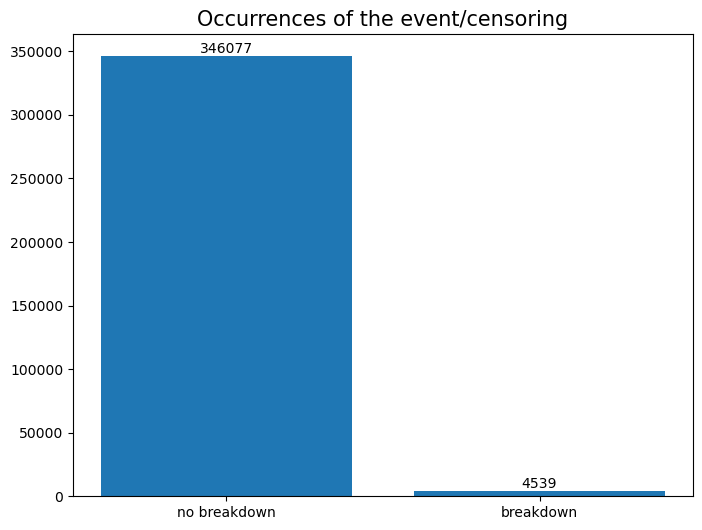

In [6]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

# creates an empty figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# counts the number of occurrences for each category (breakdown/no breakdown)
data = Counter(train['Breakdown'].replace({0:'no breakdown', 1:'breakdown'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# displays the occurences in a barchart
bars = ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Occurrences of the event/censoring', fontsize=15)

# adds count labels on top of each bar
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.show()

Number of outliers for RMSVibration.mean: 10957


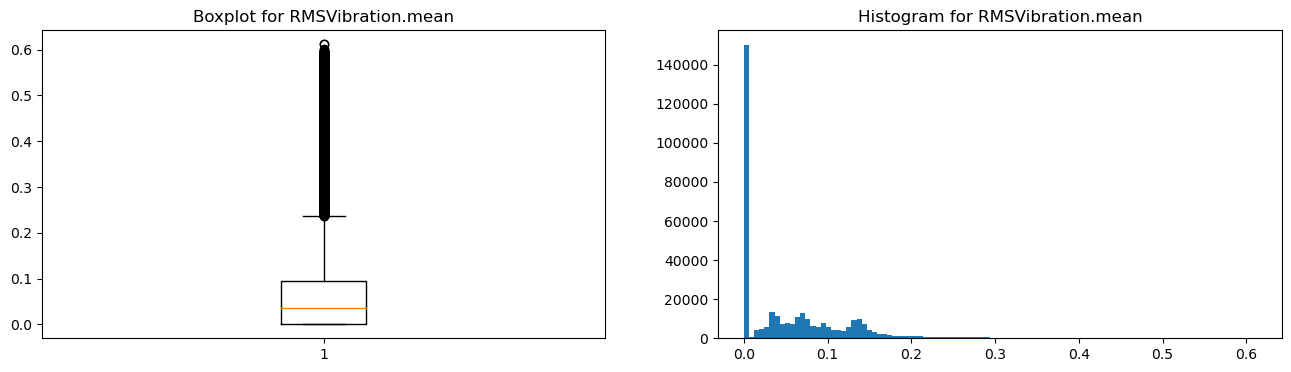

Number of outliers for Temperature.mean: 4449


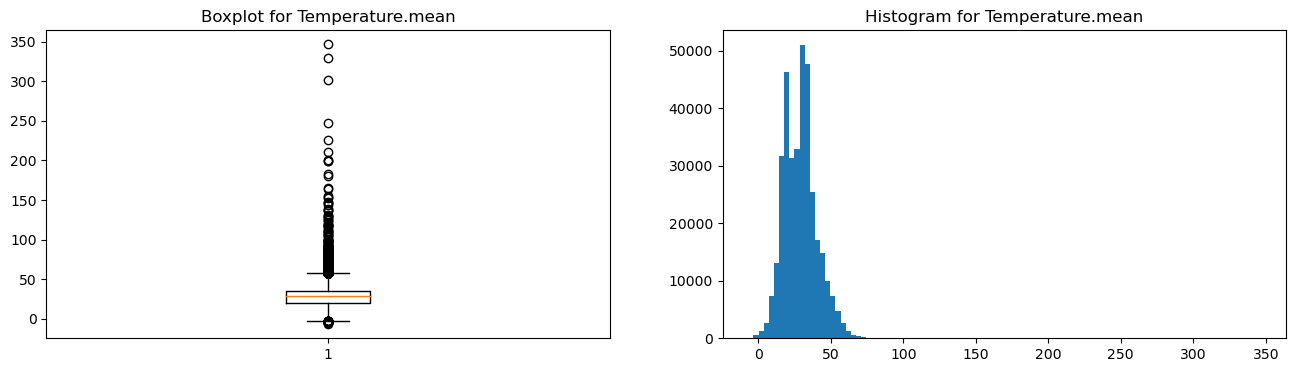

Number of outliers for SpeedPeak.mean: 34149


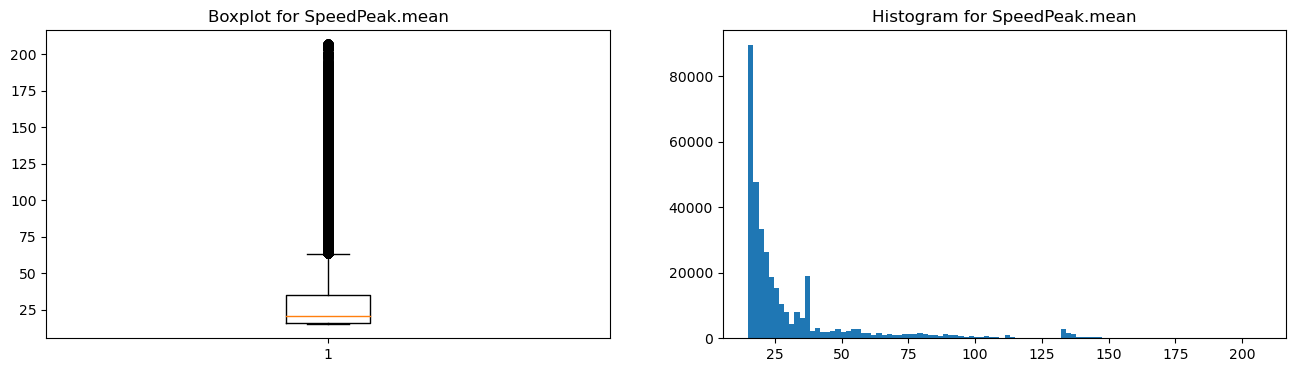

Number of outliers for Kurtosis.mean: 16318


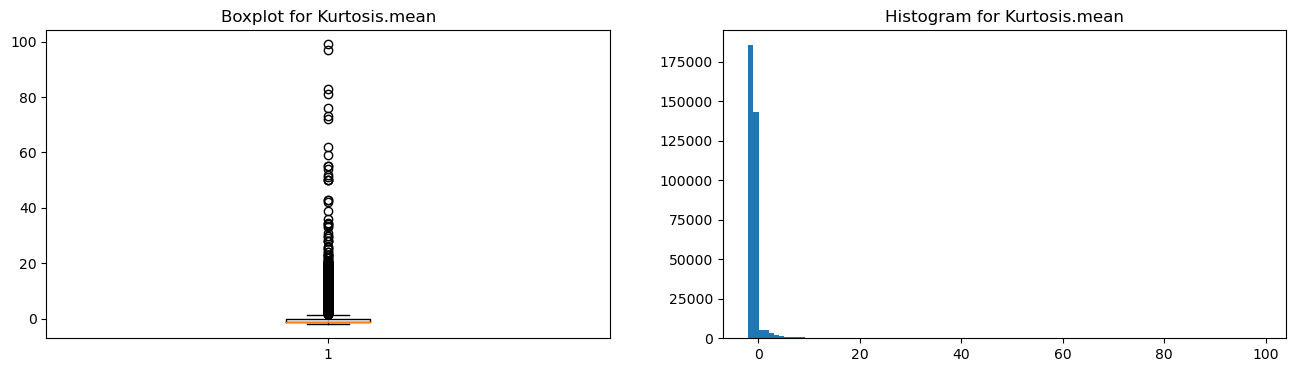

Number of outliers for RMSAcceleration.mean: 10957


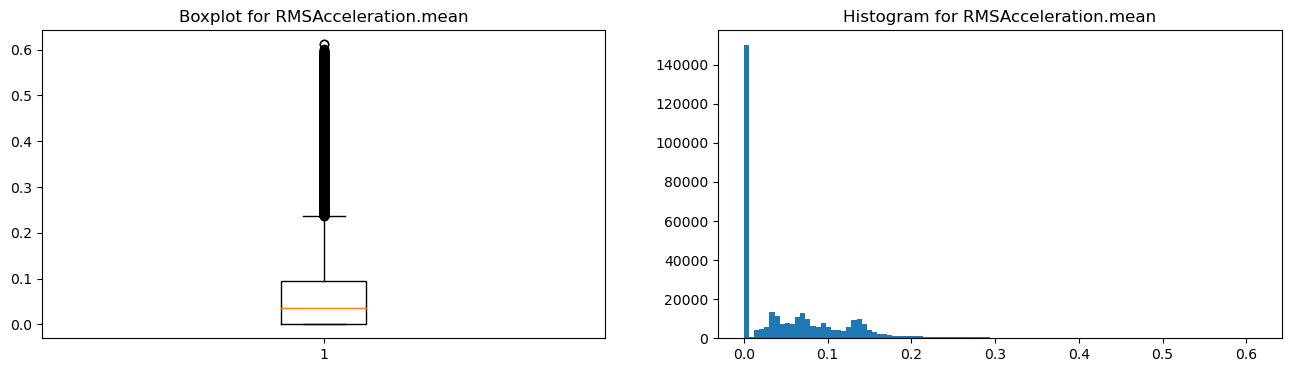

Number of outliers for Skewness.mean: 543


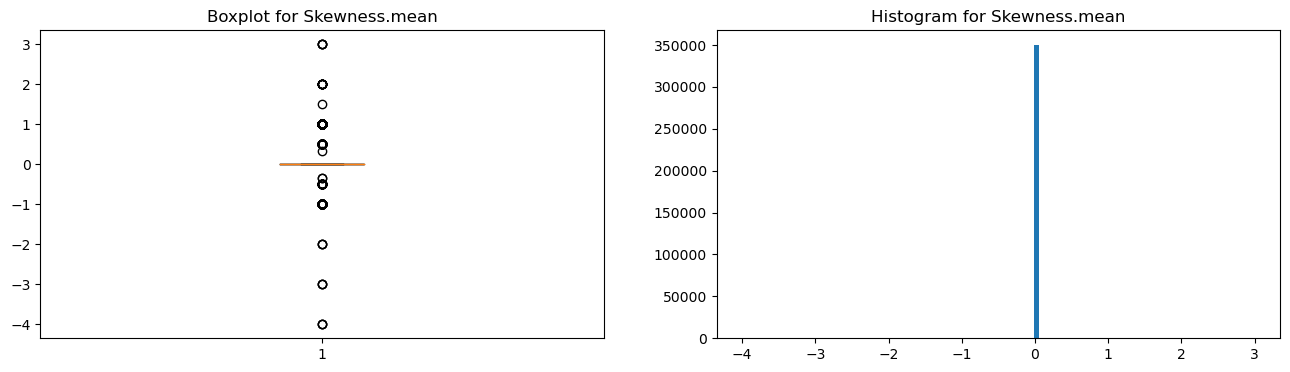

In [7]:
import matplotlib.pyplot as plt

features = ['RMSVibration.mean',  'Temperature.mean', 'SpeedPeak.mean', 'Kurtosis.mean', 'RMSAcceleration.mean', 'Skewness.mean']

for feature in features:

    # creates an empty figure
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(16, 4))

    # collects feature values
    x = train[feature].values

    # creates a boxplot
    boxplot = ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature))

    # creates a histogram
    bin_range = (x.min(), x.max())
    ax2.hist(x, bins=100, range=bin_range)
    ax2.set_title('Histogram for {}'.format(feature))

    # computes outliers
    lower_whisker = boxplot['whiskers'][0].get_ydata()[1]
    upper_whisker = boxplot['whiskers'][1].get_ydata()[1]
    outliers = sum(x < lower_whisker) + sum(x > upper_whisker)
    print("Number of outliers for {}: {}".format(feature, outliers))

    plt.show()


#### Oversampling algorithm
This code will oversample the breakdown instances, while ensuring preservation of the time series properties of the data.

In [8]:
import numpy as np

def oversampling(X, y, time_column, num_synthetic_samples=0):
    
    # identifies minority class instances (breakdown instances)
    minority_indices = np.where(y == 1)[0]
    minority_samples = X[minority_indices]
    minority_time = time_column.iloc[minority_indices]

    synthetic_samples = []
    synthetic_labels = []
    synthetic_time = []

    # calculates the standard deviation of the features (which will be used to compute the noise later on)
    minority_std = np.std(X, axis=0)
    # use standard deviations of each feature (in real data) as noise scales for each feature
    noise_level = 0.05 * minority_std  # we opted for the multiplier 0,05, because it resulted in good synthetic samples
    for _ in range(num_synthetic_samples):
        # generates noise
        noise = np.random.normal(scale=noise_level, size=minority_samples.shape)
        # infuses noise into minority class instances
        noisy_samples = minority_samples + noise

        # generates synthetic samples for each minority instance
        for i in range(len(noisy_samples)):
            alpha = np.random.rand()  # interpolation factor
            synthetic_sample = alpha * minority_samples[i] + (1 - alpha) * noisy_samples[i]
            synthetic_samples.append(synthetic_sample)
            synthetic_labels.append(1)  # synthetic intances bet a breakdown label = 1 
            synthetic_time.append(minority_time.iloc[i])  # assigns timestamp of original instance to the syntehtic instance
            
    # converts lists to np arrays
    synthetic_samples = np.array(synthetic_samples)
    synthetic_labels = np.array(synthetic_labels)

    # creates DataFrame with synthetic samples and corresponding timestamps
    df_synthetic = pd.DataFrame(data=synthetic_samples.reshape(-1, X.shape[2]), columns=[f'Feature_{i}' for i in range(X.shape[2])])
    df_synthetic['ReadableDate'] = synthetic_time

    return df_synthetic, synthetic_labels




In [9]:
# extracts features, labels, and timestamps
X_train_array = train[['RMSVibration.mean', 'Temperature.mean', 'SpeedPeak.mean', 'Kurtosis.mean', 'RMSAcceleration.mean', 'Skewness.mean']].values
y_train_array = train['Breakdown'].values
time_column = train['ReadableDate']

# applies 'oversampling' method
synthetic_df, synthetic_labels = oversampling(X_train_array.reshape(-1, 1, X_train_array.shape[1]), y_train_array, time_column)

# sythetic data is always a synthetic instance of a BREAKDOWN, so will have a breakdown label = 1
synthetic_df['Breakdown'] = synthetic_labels 

# combine real and synthetic data
total_train_df = pd.concat([train, synthetic_df.rename(columns={'Feature_0': 'RMSVibration.mean', 
                                                             'Feature_1': 'Temperature.mean', 
                                                             'Feature_2': 'SpeedPeak.mean', 
                                                             'Feature_3': 'Kurtosis.mean', 
                                                             'Feature_4': 'RMSAcceleration.mean', 
                                                             'Feature_5': 'Skewness.mean'})], ignore_index=True)

# convert 'Breakdown' column back to binary (0 or 1). Float -> Integer
total_train_df['Breakdown'] = total_train_df['Breakdown'].astype(int)

# orders the file by 'ReadableTime', as synthetic data is now just added from the back
total_train_df = total_train_df.sort_values(by='ReadableDate')

#total_train_df.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/oversampling_train.xlsx", index=False)



#### (Im)balance in Training data set & boxplots input features (AFTER oversampling):

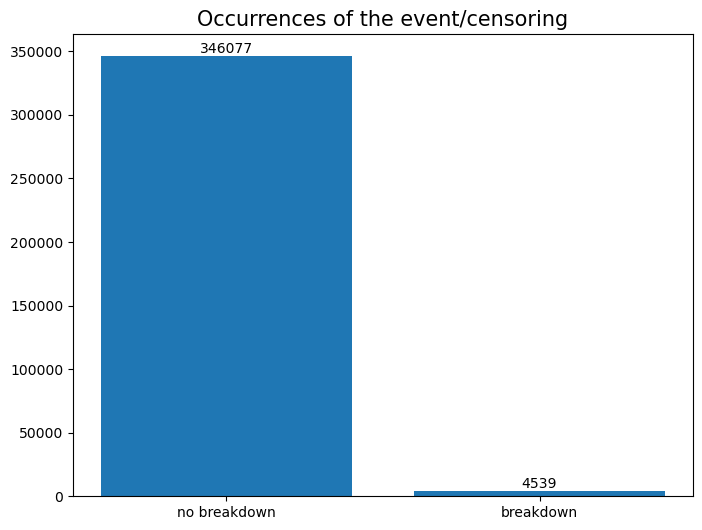

In [10]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from collections import Counter

# creates an empty figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# counts the number of occurrences for each category (breakdown/no breakdown)
data = Counter(total_train_df['Breakdown'].replace({0:'no breakdown', 1:'breakdown'}))
category = list(data.keys())
counts = list(data.values())
idx = range(len(counts))

# displays the occurences in a barchart
bars = ax1.bar(idx, counts)
ax1.set_xticks(idx)
ax1.set_xticklabels(category)
ax1.set_title('Occurrences of the event/censoring', fontsize=15)

# adds count labels on top of each bar
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(count),
             ha='center', va='bottom', fontsize=10)

plt.show()

Number of outliers for RMSVibration.mean: 200606


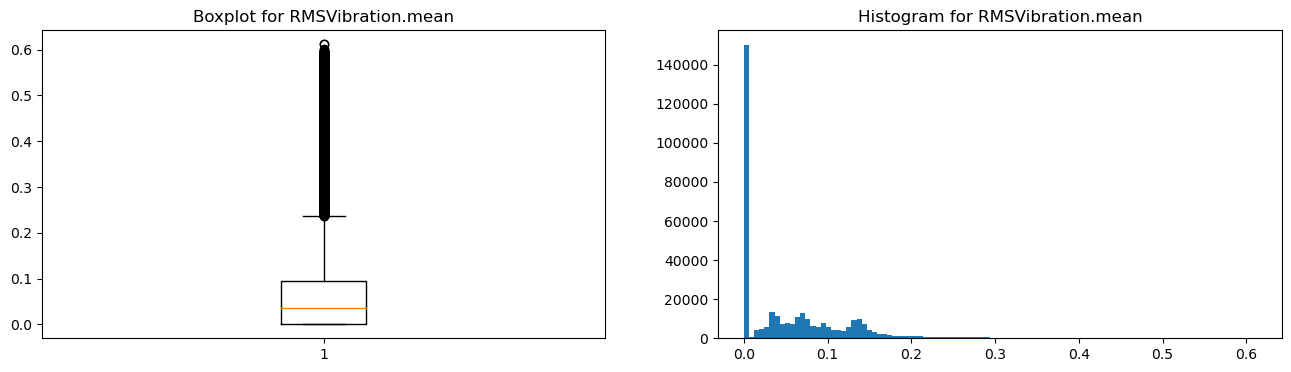

Number of outliers for Temperature.mean: 350607


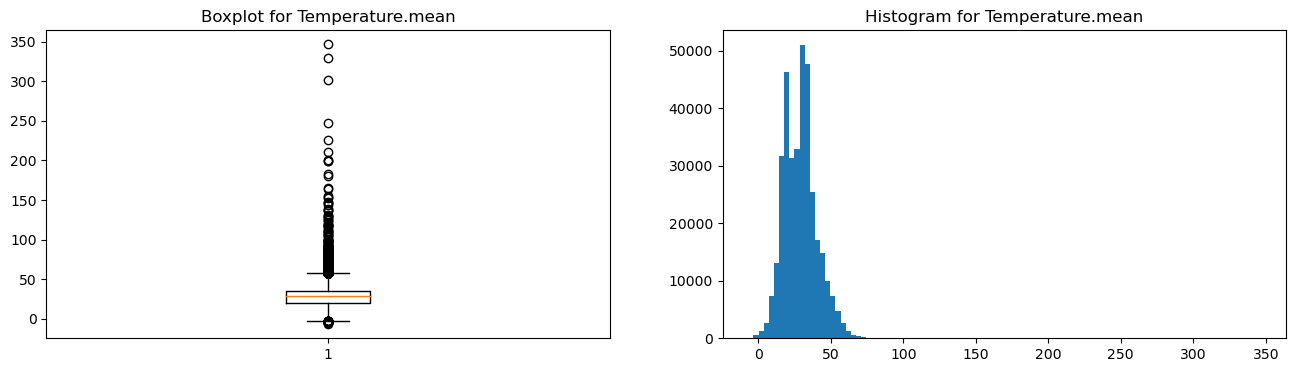

Number of outliers for SpeedPeak.mean: 350616


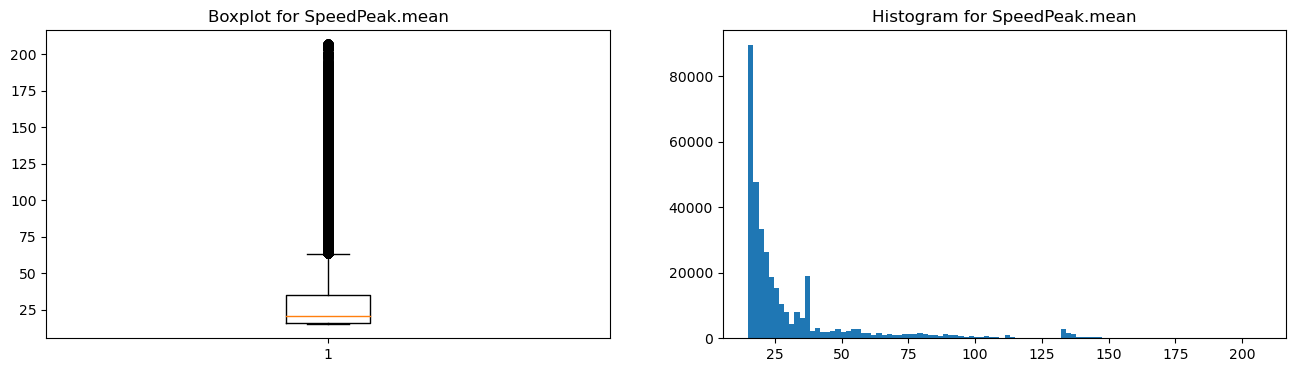

Number of outliers for Kurtosis.mean: 224090


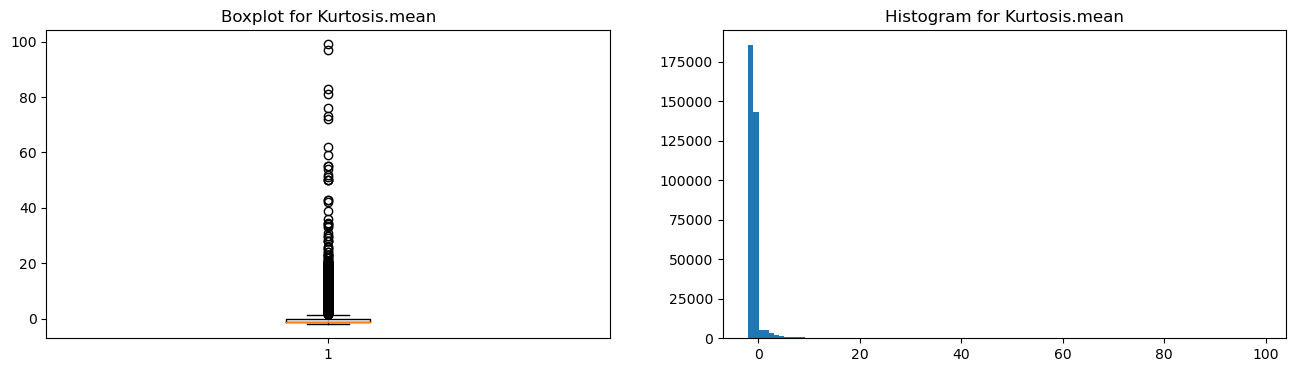

Number of outliers for RMSAcceleration.mean: 200606


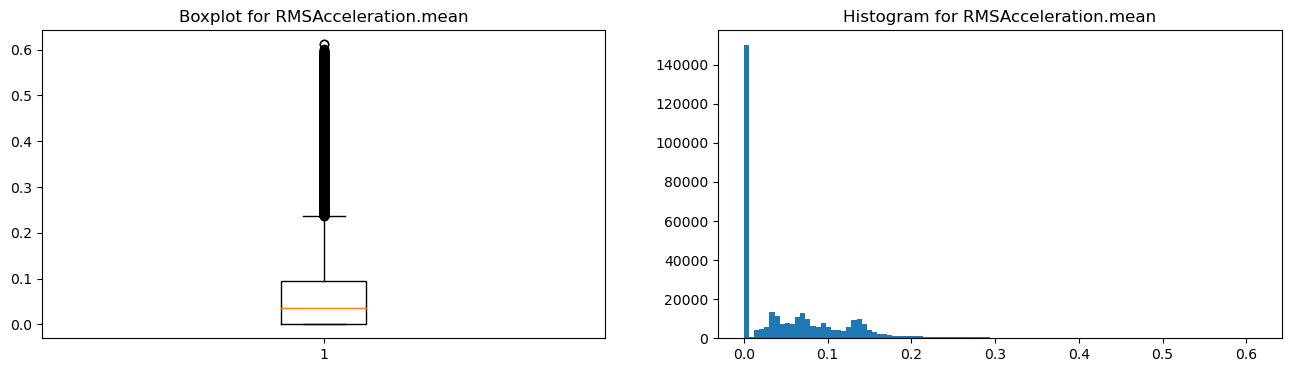

Number of outliers for Skewness.mean: 543


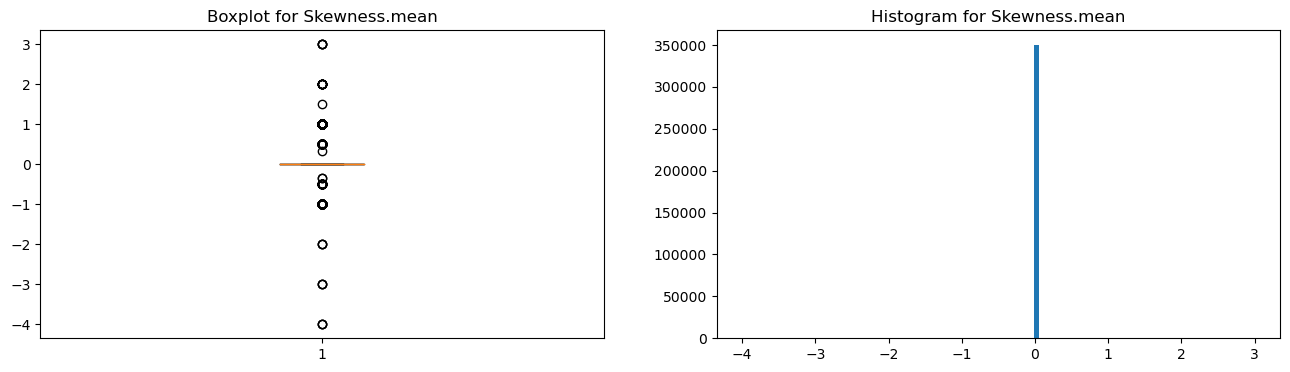

In [11]:
import matplotlib.pyplot as plt

features = ['RMSVibration.mean',  'Temperature.mean', 'SpeedPeak.mean', 'Kurtosis.mean', 'RMSAcceleration.mean', 'Skewness.mean']

for feature in features:

    # creates an empty chart 
    fig, ((ax1, ax2)) = plt.subplots(1, 2,  figsize=(16, 4))

    # collects the feature values
    x = total_train_df[feature].values

    # creates a boxplot
    ax1.boxplot(x)
    ax1.set_title('Boxplot for {}'.format(feature) )

    # creates a histogram
    bin_range = (x.min(), x.max())  
    ax2.hist(x, bins=100, range=bin_range)  
    ax2.set_title('Histogram for {}'.format(feature))
    
    # computes outliers
    lower_whisker = boxplot['whiskers'][0].get_ydata()[1]
    upper_whisker = boxplot['whiskers'][1].get_ydata()[1]
    outliers = sum(x < lower_whisker) + sum(x > upper_whisker)
    print("Number of outliers for {}: {}".format(feature, outliers))

    plt.show()

#### Extra feature: "Active"

In [12]:
import pandas as pd

# combine the train, test and validation set again, to add & compute the 'Active' column
total_data = pd.concat([total_train_df, validation, test], ignore_index=True)

# initializes variable to store the last 'active' value before a breakdown
last_active_value = None

# initializes variable to store the end date of the last breakdown
breakdown_end_date = pd.Timestamp("8/31/2022 12:05:20 PM") # initialized, based on justifications 08/2022
# This should be initialized based on the last breakdown in August, as sensor data starts on 01/09/2022. 
# So, we need to manually retrieve it from the justification of August 2022. 
# Otherwise, we would need to delete all rows before the first breakdown in September.



# iterates over the DataFrame to calculate the number of days since the previous breakdown
# first we did not have the breakdown_end_date (because we did not have access to the justifications file from August 2022), therefore there are some ifs that contain: 'if breakdown_end_data is None'.    
for i in range(len(total_data)):
    if total_data.loc[i, 'Breakdown'] == 0:
        if breakdown_end_date is None:
            # if no previous breakdown, set 'Active' to 0
            total_data.loc[i, 'Active'] = 0
        else:
            # calculates the number of days since the previous breakdown
            days_since_last_breakdown = (total_data.loc[i, 'ReadableDate'] - breakdown_end_date).days
            # assign the number of days since the previous breakdown to the corresponding row
            total_data.loc[i, 'Active'] = days_since_last_breakdown
    else:
        # updates the last active value (if breakdown event)
        last_active_value = total_data.loc[i, 'ReadableDate']
        # calculates the number of days since the previous breakdown (if there was a previous breakdown)
        if last_active_value is not None and breakdown_end_date is not None:
            days_since_last_breakdown = (last_active_value - breakdown_end_date).days
            # assigns the number of days since the previous breakdown to the corresponding row
            total_data.loc[i, 'Active'] = days_since_last_breakdown
        else:
            # if no previous breakdown, 'Active' remains 0
            total_data.loc[i, 'Active'] = 0
        
    # if it's the end of a breakdown event (can last multiple sensor readings), update the breakdown end date and reset the counter
    if total_data.loc[i, 'Breakdown'] == 1 and (i == len(total_data) - 1 or total_data.loc[i + 1, 'Breakdown'] == 0):
        breakdown_end_date = total_data.loc[i, 'ReadableDate']
        total_data.loc[i + 1, 'Active'] = 0
        
#total_data.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/final_data.xlsx", index=False)


In [13]:
# splits the data into train and test sets based on the split_dates (again)
final_train = total_data[total_data['ReadableDate'] < split_date1]
final_validation = total_data[(total_data['ReadableDate'] >= split_date1) & (total_data['ReadableDate'] < split_date2)]
final_test = total_data[total_data['ReadableDate'] >= split_date2]


#### Optimization
--> Course Data Science: "One popular trial-and-error approach to determine the optimal class distribution works as follows: In the first step, a classifier is built on the original data set with the skewed class distribution, which has, for example, 99% non-fraudsters and 1% fraudsters. The AUC of this model is then recorded on an independent validation data set. In a next step, under- or oversampling is used to change the class distribution to for example, 90% and 10%. Again, the AUC of the model is recorded. Subsequent models are built on samples of 85% versus 15%, 80% versus 20%, 75% versus 25%, and so on. Each time the AUC is recorded. After the AUC starts to stagnate or drop, the procedure stops and the optimal odds ratio is found."

--> We will now run the provided code multiple times, incrementing the "num_synthetic_samples" parameter by 5 in the oversampling() method with each execution. Subsequently, the resulting datasets will be utilized to train a model with the optimized parameters: baseline_estimation_method = "breslow", l1_ratio = 0.35 and penalizer = 0.1

--> The optimized "num_synthetic_samples", will be the one that yields the largest c-index.

In [17]:
from lifelines import CoxPHFitter

train_df = final_train.drop(columns=['ReadableDate'])

validation_df = final_validation.drop(columns=["ReadableDate"])

# instantiates and fits the Cox Proportional Hazards model using optimized parameters (Best params: baseline_estimation_method = "breslow", penalizer=0.01, l1_ratio=0.35)
coxPH2 = CoxPHFitter(baseline_estimation_method = "breslow", penalizer=0.01, l1_ratio=0.35)
coxPH2.fit(train_df, duration_col='Active', event_col='Breakdown')

c_index = coxPH2.score(df=validation_df, scoring_method='concordance_index')
print("Concordance Index (C-index):", c_index)



Concordance Index (C-index): 0.6557867352535919


| Num Synthetic Samples | Concordance Index (C-index) |
|-----------------------|-----------------------------|
| 0                     | 0.6557867352535919          |
| 5                     | 0.6438870857737757          |
| 10                    | 0.6463352317455244          |
| 15                    | 0.6477974912369954          |
| 20                    | 0.6486574237491332          |
| 25                    | 0.6492198001256169          |
| 30                    | 0.6488369823236282          |
| 35                    | 0.6473242535895701          |
| ...                   | ...                         |







# Data processing
### Fitting Cox Proportional Hazards model (TRAINING DATA + VALIDATION DATA)

After optimizing the hyperparameters using the validation set, it's common practice to retrain the model using both the training and validation sets combined. This larger dataset can potentially provide more information to the model, leading to better generalization performance.

--> Train model on train + validation

In [18]:
import pandas as pd
from lifelines import CoxPHFitter

# instantiates and fits the Cox Proportional Hazards model using optimized parameters (Best params: baseline_estimation_method = "breslow", penalizer=0.01, l1_ratio=0.35)
coxPH3 = CoxPHFitter(baseline_estimation_method = "breslow", penalizer=0.01, l1_ratio=0.35)
train_df = pd.concat([final_train, final_validation], ignore_index=True).drop(columns=['ReadableDate'])
coxPH3.fit(train_df, duration_col='Active', event_col='Breakdown')

<lifelines.CoxPHFitter: fitted with 425748 total observations, 420713 right-censored observations>

### RUL-predictions
We estimate the RUL, by using the method predict_expectation(). This method integrates the total survival funtion, which result in the expected lifetime (E[T]). This expected lifetime can be interpreted as a prediction for the estimated RUL.

In [19]:
test_df = final_test.drop(columns = ["ReadableDate"])

# predicts expected lifetime for the test set (= expected RUL)
predicted_rul_COX_test = coxPH3.predict_expectation(test_df)
print(predicted_rul_COX_test)

# calculate c-index on the test set
c_index_test = coxPH3.score(df=test_df, scoring_method='concordance_index')

print("Concordance Index (C-index) on Test Set:", c_index_test)

425748    61.202327
425749    61.202327
425750    61.202327
425751    61.202327
425752    61.202327
            ...    
500875    61.202327
500876    61.202327
500877    61.202327
500878    61.202327
500879    61.202328
Length: 75132, dtype: float64
Concordance Index (C-index) on Test Set: 0.4732019927355586


#### RUL predictions vs True RUL (plot)

In [ ]:
breakdown_times = final_test[final_test['Breakdown'] == 1]['ReadableDate']

True_RUL = []
# calcualtes the true RUL for each instance in the test set
for index, row in final_test.iterrows():
    if not breakdown_times.empty and breakdown_times.iloc[0] == row['ReadableDate']:
        True_RUL.append(0)
        breakdown_times = breakdown_times.drop(breakdown_times.index[0])
    else:
        if not breakdown_times.empty:
            time_until_next_breakdown = (breakdown_times.iloc[0] - row['ReadableDate']).total_seconds() / (3600*24)  # converts seconds to days
            True_RUL.append(time_until_next_breakdown)
        else:
            True_RUL.append(None)  # no more breakdowns after this point, last rows have a NaN as 'True_RUL'

            
final_test["prediction"] = predicted_rul_COX_test
final_test['True_RUL'] = True_RUL
#final_test.to_excel("/Users/wardmestdagh/Documents/HIRB/THESIS/DOCUMENTEN PURATOS/SENSOR DATA/final_test_data.xlsx", index=False)

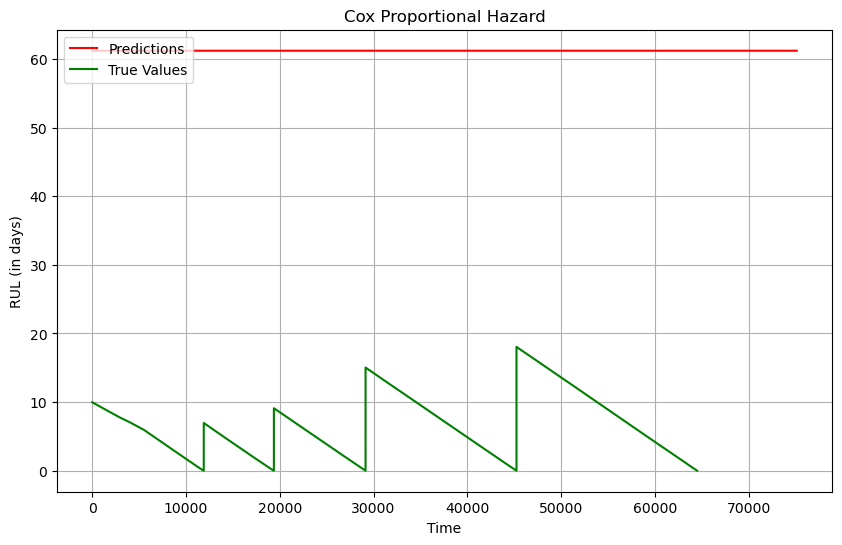

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# resets index of test set, such that x-axis is correct in the plot
final_test.reset_index(drop=True, inplace=True)

# plots the 'True_RUL' and the 'Predictions' (which represent the predicted RUL)
plt.figure(figsize=(10, 6))
plt.plot(final_test['prediction'], label='Predictions', color='red')
plt.plot(final_test['True_RUL'], label='True Values', color='green')
plt.xlabel('Time')
plt.ylabel('RUL (in days)')
plt.title('Cox Proportional Hazard')
plt.legend(loc='upper left')
plt.grid(True)

# saves the plot as a pdf
plt.savefig('RUL_CoxPH.pdf')

plt.show()

### Test Proportional Hazard Assumption
To use the model, the Proportional Hazard Assumption must be met. 

In [160]:
from lifelines.statistics import proportional_hazard_test
# performs Schoenfeld Residuals Test, which tests the Proportional Hazard assumption
results = proportional_hazard_test(coxPH3, train_df , time_transform='rank')
print(results)

<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 425748 total observations, 420713 right-censored observations>
         test_name = proportional_hazard_test

---
                      test_statistic    p  -log2(p)
Kurtosis.mean                   0.00 1.00      0.00
RMSAcceleration.mean            0.00 0.99      0.01
RMSVibration.mean               0.00 1.00      0.00
Skewness.mean                   0.00 1.00      0.00
SpeedPeak.mean                  0.00 1.00      0.00
Temperature.mean                0.00 0.99      0.01
